##  Import

In [0]:
# # Reason: https://github.com/raghakot/keras-vis/issues/182
# Imported below (heatmap section) as other libraries need higher verion of scipy
# !pip install scipy==1.2.*
import cv2
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Activation, Concatenate
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adadelta
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.regularizers import l2

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# from vis.utils import utils
# from vis.visualization import visualize_cam
from scipy import interp
from itertools import cycle

import imgaug as ia
import imgaug.augmenters as iaa

Using TensorFlow backend.


In [0]:
# from google.colab import drive

def load_drive():
  # drive.mount('/content/drive')
  base_dir = '/content/drive/My Drive/COVID/'
  return base_dir

#  Models

### > DenseNet

In [0]:
def denseNet(image_shape=(256, 256, 3)):
  input_layer = Input(shape=image_shape)
  model = keras.applications.DenseNet121(include_top=True, weights=None, input_tensor=input_layer, input_shape=None, pooling=None, classes=3)
  return model

### > AlexNet

In [0]:
def alexnet_model(img_shape=(256, 256, 3), n_classes=3, l2_reg=0., weights=None):

	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(64, (11, 11), input_shape=img_shape, padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(32, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(32, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

 	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(32, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(32, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(768))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(512))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

### > SimpleCNN

In [0]:
def simpleCNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(256, 256, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (5, 5)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    
    return model

### > MobileNet

In [0]:
def mobilenet_model(image_shape=(256, 256, 3)):
  input_layer = Input(shape=image_shape)
  model = keras.applications.MobileNetV2(include_top=True, weights=None, input_tensor=input_layer, input_shape=None, pooling=None, classes=3, alpha=1.0)
  return model

### > AlexNet V2

In [0]:
def alexnetv2_model(image_shape=(256, 256, 3)):
  model = Sequential()  

  #1 conv layer
  model.add(SeparableConv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="same",activation="relu",input_shape=image_shape))

  #1 max pool layer
  model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

  model.add(BatchNormalization())

  #2 conv layer
  model.add(SeparableConv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="same",activation="relu"))

  #2 max pool layer
  model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

  model.add(BatchNormalization())

  #3 conv layer
  model.add(SeparableConv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))

  #4 conv layer
  model.add(SeparableConv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))

  #5 conv layer
  model.add(SeparableConv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))

  #3 max pool layer
  model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

  model.add(BatchNormalization())

  model.add(Flatten())

  #1 dense layer
  model.add(Dense(4096,activation="relu"))

  model.add(Dropout(0.4))

  model.add(BatchNormalization())

  #2 dense layer
  model.add(Dense(2048,activation="relu"))

  model.add(Dropout(0.4))

  model.add(BatchNormalization())

  #output layer
  model.add(Dense(3,activation="softmax"))

  model.summary()
  return model

### > Separable

In [0]:
def separable_model(image_shape=(256, 256,3)):
  input_img = Input(shape=image_shape, name='ImageInput')
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
  x = MaxPooling2D((2,2), name='pool1')(x)
  
  x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
  x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
  x = MaxPooling2D((2,2), name='pool2')(x)
  
  x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
  x = BatchNormalization(name='bn1')(x)
  x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
  x = BatchNormalization(name='bn2')(x)
  x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
  x = MaxPooling2D((2,2), name='pool3')(x)
  
  x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
  x = BatchNormalization(name='bn3')(x)
  x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
  x = BatchNormalization(name='bn4')(x)
  x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
  x = MaxPooling2D((2,2), name='pool4')(x)
  
  x = Flatten(name='flatten')(x)
  x = Dense(1024, activation='relu', name='fc1')(x)
  x = Dropout(0.7, name='dropout1')(x)
  x = Dense(512, activation='relu', name='fc2')(x)
  x = Dropout(0.5, name='dropout2')(x)
  x = Dense(3, activation='softmax', name='fc3')(x)

  model = Model(inputs=input_img, outputs=x)
  
  base = keras.applications.VGG16(include_top=False, weights="imagenet", input_tensor=input_img)
  base.summary()

  model.layers[1].set_weights(base.layers[1].get_weights())
  model.layers[2].set_weights(base.layers[2].get_weights())
  model.layers[4].set_weights(base.layers[4].get_weights())
  model.layers[5].set_weights(base.layers[5].get_weights())

  model.summary()
  
  return model

### > Custom Separable Convolution

In [0]:
def separablenet_model(image_shape=(256, 256, 3)):

  separablenet = Sequential()

	# Layer 1
  separablenet.add(Conv2D(64, (3, 3), input_shape=image_shape, padding='same'))
  separablenet.add(Activation('relu'))
  separablenet.add(BatchNormalization())
  separablenet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
  separablenet.add(SeparableConv2D(128, (3, 3), padding='same'))
  separablenet.add(Activation('relu'))
  separablenet.add(BatchNormalization())
  separablenet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
  separablenet.add(ZeroPadding2D((1, 1)))
  separablenet.add(SeparableConv2D(256, (3, 3), padding='same'))
  separablenet.add(Activation('relu'))
  separablenet.add(BatchNormalization())
  separablenet.add(MaxPooling2D(pool_size=(2, 2)))

 	# Layer 4
  separablenet.add(ZeroPadding2D((1, 1)))
  separablenet.add(SeparableConv2D(512, (3, 3), padding='same'))
  separablenet.add(Activation('relu'))
  separablenet.add(BatchNormalization())
	
	# Layer 5
  separablenet.add(ZeroPadding2D((1, 1)))
  separablenet.add(SeparableConv2D(512, (3, 3), padding='same'))
  separablenet.add(Activation('relu'))
  separablenet.add(BatchNormalization())
  separablenet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
  separablenet.add(Flatten())
  separablenet.add(Dense(1024))
  separablenet.add(Activation('relu'))
  separablenet.add(BatchNormalization())
  separablenet.add(Dropout(0.8))

	# Layer 7
  separablenet.add(Dense(512))
  separablenet.add(Activation('relu'))
  separablenet.add(BatchNormalization())
  separablenet.add(Dropout(0.8))

	# Layer 8
  separablenet.add(Dense(3))
  separablenet.add(BatchNormalization())
  separablenet.add(Activation('softmax'))

  input_img = Input(shape=image_shape, name='ImageInput')
  base = keras.applications.VGG16(include_top=False, weights="imagenet", input_tensor=input_img)
  base.summary()
  separablenet.summary()
 

  separablenet.layers[0].set_weights(base.layers[1].get_weights())
  
  return separablenet

### > ResNet50

In [0]:
def resNet50(image_shape = (256,256,3)):
    input_layer = Input(shape=image_shape)
    model = keras.applications.ResNet50(include_top=True, weights=None, input_tensor=input_layer, input_shape=None, pooling=None, classes=3)
    return model

### > SqueezeNet

In [0]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights=None,
               input_tensor=None, input_shape=(256,256,3),
               pooling=None,
               classes=3):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

### > Transfer Inception

In [0]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

from keras import backend as K

from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False , input_shape=(256, 256, 3))

x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(3, activation='sigmoid')(x)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


# Helper Functions

### > Visualize

In [0]:
def visualize_all():
  print("Complete=> X data shape: ", x.shape, ". Y data shape: ", y.shape)
  print(np.unique(y, return_counts=True))

  covid = x[y == 0]
  normal = x[y == 1]
  viral = x[y == 2]

  fig = plt.figure(figsize=(10, 10))

  for i in range(5):
    fig.add_subplot(3, 5, i + 1)
    plt.imshow(covid[i])

  for i in range(5):
    fig.add_subplot(3, 5, 5 + i + 1)
    plt.imshow(viral[i])

  for i in range(5):
    fig.add_subplot(3, 5, 10 + i + 1)
    plt.imshow(normal[i])

  plt.show()

def visualize_input(x):
  print(x.shape)

  fig = plt.figure(figsize=(10, 10))

  for i in range(15):
    fig.add_subplot(3, 5, i + 1)
    plt.imshow(x[i])

  plt.show()

### > Shuffle

In [0]:
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

### > Reshape

In [0]:
def reshape(c):
  reshaped = np.empty((len(c), 256, 256, 3), dtype = np.uint8)
  dim = (256, 256)

  for i in range(len(c)):
    assert(c[i].shape == (512, 512, 3))
    reshaped[i] = cv2.resize(c[i], dim, interpolation = cv2.INTER_CUBIC)
  
  del c
  return reshaped

### > Augmentation

In [0]:
def oversampling(X_rare, seed_value):
  ia.seed(seed_value)

  seq = iaa.Sequential([
      # iaa.Fliplr(1),
      # iaa.Sometimes(
      #     0.5,
      #     iaa.GaussianBlur(sigma=(0, 0.5))
      # ),
      iaa.LinearContrast((0.95, 1.05)),
      iaa.Multiply((0.98, 1.05)),
      iaa.Affine(
          scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
          translate_percent={"x": (-0.02, 0.02), "y": (-0.02, 0.02)},
          rotate=(-5, 5),
          shear=(-2, 2),
          mode="reflect"
      )
  ], random_order=True) # apply augmenters in random order

  return (seq(images=X_rare))

### > Training

In [0]:
def train(model, save_name):

  opt = keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

  datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.005,
        zoom_range=0.01,
        # horizontal_flip=True,
        fill_mode='reflect')
  datagen.fit(X_train)

  # Consider class weight
  weight = {0: 1.2, 1: 1.0, 2: 1.0}

  # Consider early stopping
  save_path = "/content/drive/My Drive/COVID/DD/models/" + save_name + "_{val_accuracy}.hdf5"
  chkpt = ModelCheckpoint(save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  history = model.fit(datagen.flow(X_train, Y_train, batch_size=16),
          # epochs = 50,
          epochs = 60,
          shuffle = True,
          steps_per_epoch=len(X_train) // 16,
          validation_data=(X_test, Y_test),
          class_weight=weight,
          callbacks=[chkpt])
  
  return history

### > Evaluation

In [0]:
def plot_data(history):
  print(history.history.keys())

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [0]:
def display_metrics(model):
  target_names = ['COVID-19', 'Normal', 'Viral Pneumonia']
  y_true = np.argmax(Y_test, axis=1)

  y_pred = np.argmax(model.predict(X_test), axis=1)
  
  print(classification_report(y_true, y_pred, target_names=target_names, digits=6))
  print('Confusion Matrix')
  print(confusion_matrix(y_true, y_pred))

  del y_true
  del y_pred

# Main

### > Load Data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Complete=> X data shape:  (2318, 512, 512, 3) . Y data shape:  (2318,)
(array([0, 1, 2]), array([ 170, 1072, 1076]))


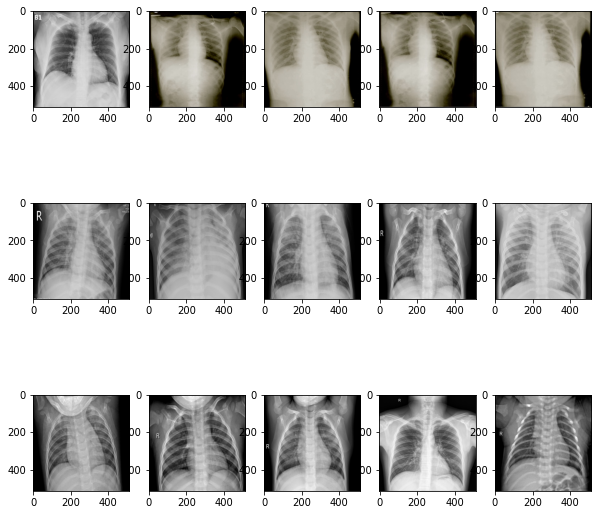

(array([0, 1, 2]), array([138, 868, 871]))
(array([0, 1, 2]), array([ 32, 204, 205]))


In [0]:
# Load data
base_dir = load_drive()
x = np.load(base_dir + 'data/trainx.npy')
y = np.load(base_dir + 'data/trainy.npy')

# Visualize
visualize_all()

# Test-train split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.19, shuffle=True, stratify=y)

del x
del y

# Sanity check after split
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

### > Preprocess

In [0]:
# Reshape
X_train = reshape(X_train)
X_test = reshape(X_test)

# Sanity Check
print(X_train.shape)
print(X_test.shape)

(1877, 256, 256, 3)
(441, 256, 256, 3)


(138, 256, 256, 3)


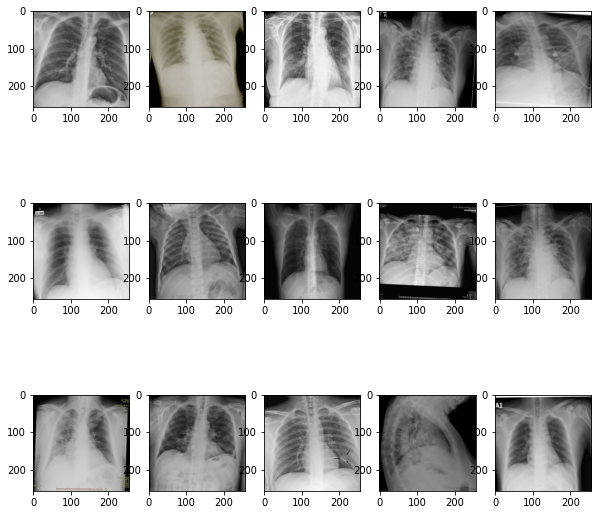

(138, 256, 256, 3)


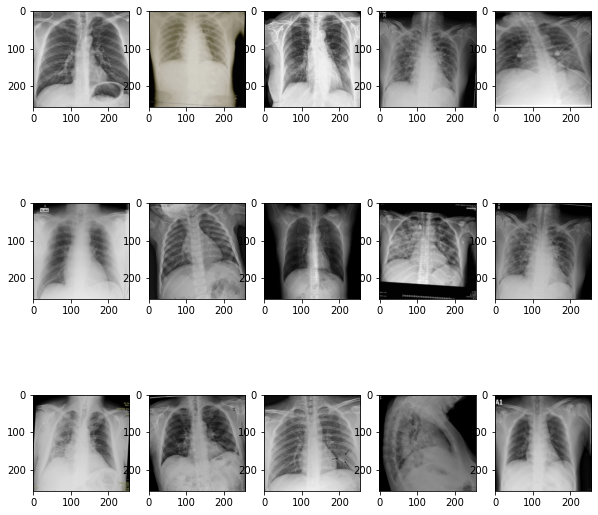

(138, 256, 256, 3) (138, 256, 256, 3)


In [0]:
# Oversampling
rare_label = 0

img_aug1 = oversampling(X_train[Y_train == rare_label], 42)
img_aug2 = oversampling(X_train[Y_train == rare_label], 5)

visualize_input(img_aug1)
visualize_input(img_aug2)

assert(np.array_equal(img_aug1, img_aug2) == False)
print(img_aug1.shape, img_aug2.shape)

In [0]:
# Append augmented images to original data
total_auglen = len(img_aug1) + len(img_aug2)

print("Total number of augmneted samples: ", total_auglen)

X_train = np.concatenate((X_train, img_aug1))
X_train = np.concatenate((X_train, img_aug2))
Y_train = np.concatenate((Y_train, np.tile(rare_label, total_auglen)))

del img_aug1
del img_aug2

# Shuffle data
X_train, Y_train = unison_shuffle(X_train, Y_train)

# Preprocess
X_train = (X_train.astype('float32')) / 255.0
X_test = (X_test.astype('float32')) / 255.0

# One-hot encoding
Y_train = np_utils.to_categorical(Y_train, 3, dtype='int32')
Y_test = np_utils.to_categorical(Y_test, 3, dtype='int32')

Total number of augmneted samples:  276


## Models

### > Run Custom Separable Convolution

In [0]:
model_name = 'separablenet_model'
model = separablenet_model((256, 256, 3))
history = train(model, model_name) 
plot_data(history)

In [0]:
# model = load_model('')
display_metrics(model)

### > ROC

In [0]:
# # Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem


# # y_test must be one-hot vector, uncomment if needed
# # y_test = np.argmax(Y_test, axis=1)

# y_prob = model.predict(X_test)

In [0]:
# print(y_test.shape, y_prob.shape)
# macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
#                                   average="macro")
# weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
#                                      average="weighted")
# macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
#                                   average="macro")
# weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
#                                      average="weighted")
# print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
#       "(weighted by prevalence)"
#       .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
# print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
#       "(weighted by prevalence)"
#       .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

(441,) (441, 3)
One-vs-One ROC AUC scores:
0.998671 (macro),
0.998567 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.998683 (macro),
0.998257 (weighted by prevalence)


### > Heatmap

In [0]:
# # Reason: https://github.com/raghakot/keras-vis/issues/182
# !pip install scipy==1.2.*

# from vis.utils import utils
# from vis.visualization import visualize_cam

# base_dir = load_drive()
# x = np.load(base_dir + 'data/trainx.npy')
# y = np.load(base_dir + 'data/trainy.npy')

# c = x[y == 0]
# n = x[y == 1]
# v = x[y == 2]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# x_gradcam = np.concatenate((c[0:10], n[0:10]))
# x_gradcam = np.concatenate((x_gradcam, v[0:10]))
# x_gradcam = reshape(x_gradcam)
# x_gradcam = (x_gradcam.astype('float32')) / 255.0
# print(x_gradcam.shape)

In [0]:
# model = load_model('/content/drive/My Drive/COVID/DD/models/separablenet.hdf5')
# model.summary()

In [0]:
# # Reference: https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb
# last = 'separable_conv2d_22'
# layer_idx = utils.find_layer_idx(model, last)
# model.layers[layer_idx].activation = keras.activations.linear
# model = utils.apply_modifications(model)

In [0]:
# penultimate_layer = utils.find_layer_idx(model, "separable_conv2d_21")
# for i in range(30):
#   img = x_gradcam[i]
#   # Reference: https://raghakot.github.io/keras-vis/vis.visualization/
#   grad_top = visualize_cam(model, 
#                            layer_idx, 
#                            filter_indices=2, 
#                            seed_input=img,
#                            penultimate_layer_idx=penultimate_layer,
#                            backprop_modifier=None,
#                            grad_modifier=None)
#   if i==0:
#       print('First sample')
#   else:
#       fig.clf()

#   r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
#   _img = 0.2989 * r + 0.5870 * g + 0.1140 * b
#   fig, axes = plt.subplots(1,2,figsize=(14,5))
#   axes[0].imshow(img)
#   axes[1].imshow(_img)
#   j = axes[1].imshow(grad_top,cmap="jet",alpha=0.8)
#   fig.colorbar(j)
#   fig1 = plt.gcf()
#   # save_path = "/content/drive/My Drive/COVID/DD/screenshots/gradcam_" + str(i) + ".png"
#   # print(save_path)
#   # fig1.savefig(save_path)
#   plt.show()